# **Handout 2: Unsupervised Learning (Problem 2)**
### *Author: Miruna Andreea Gheata*

***

### Table of Contents
   
* [1. Function definitions](#first-bullet)
   *  [1.1. Plotting functions](#first-first-bullet)
   *  [1.2. Clustering functions (General)](#first-second-bullet)
   *  [1.3. Clustering functions (Crisp clustering)](#first-third-bullet)
   *  [1.4. Clustering functions (Fuzzy clustering)](#first-fourth-bullet)
* [2. Loading the data](#second-bullet)
* [3. Crisp Clustering](#third-bullet)
   *  [3.1. Results](#third-first-bullet)
   *  [3.2. Predicted clusters](#third-second-bullet)
   *  [3.3. Cost evolution](#third-third-bullet)
* [4. Fuzzy Clustering](#fourth-bullet)
   *  [4.1. Results](#fourth-first-bullet)
   *  [4.2. Predicted clusters](#fourth-second-bullet)
   *  [5.3. Cost evolution](#fourth-third-bullet)
***


In this exercise we will find the clustering of points that form a line. There are 3 clusters in total, and all the "lines" are overlapped. Crisp clustering and fuzzy clustering will be applied to the dataset.

- **Crisp clustering:** Form of clustering in which each data point can belong to **only one** cluster. 

- **Fuzzy clustering:** Also referred to as soft clustering or soft k-means, fuzzy clustering is a form of clustering in which each data point can belong to **more than one** cluster.

### *0.1. Library imports*

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import sys
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix

***

## **1. Function definitions** <a class="anchor" id="first-bullet"></a>

### **1.1. Plotting functions** <a class="anchor" id="first-first-bullet"></a>

In [2]:
def scatter_plot(X, y, title, xlabel, ylabel, miss=None):
    '''
    Plots the clusters of points. 
    '''
    plt.figure(figsize=(15, 10))
    # Plot the points of each cluster
    plt.scatter(X[np.where(y == 0)[0]][:, 0], X[np.where(y == 0)[0]][:, 1], marker='+', color='#A2D9CE',
                label='class 0')
    plt.scatter(X[np.where(y == 1)[0]][:, 0], X[np.where(y == 1)[0]][:, 1], marker='*', color='#3CB371',
                label='class 1')
    plt.scatter(X[np.where(y == 2)[0]][:, 0], X[np.where(y == 2)[0]][:, 1], marker='.', color='#90CAF9',
                label='class 2')
    # If miss is passed, plot the missclassified points
    if miss:
        plt.scatter(X[miss][:, 0], X[miss][:, 1], marker='+', color='#FF0000', label='misclassified')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.legend()
    plt.title(title)
    plt.show(block=False)

In [3]:
def plot_cost(cost_evolution, mode):
    '''
    Plots the cost evolution for the given clustering approach (mode = Fuzzy/Crisp).
    '''
    plt.figure(figsize=(15, 10))
    plt.plot(cost_evolution)
    plt.title(f"Cost evolution ({mode} Clustering)")
    plt.ylabel("Cost")
    plt.ylim(bottom=0)
    plt.show()

In [4]:
def plot_predicted_clusters(X, y_pred, u, mode):
    '''
    Plots the predicted clusters and the missclassified points. 
    '''
    # Get missclassified points. 
    missclassified = get_misclassified(np.reshape(y_pred, -1))

    # Check if missclassified points are correct.
    removed_missclassified = check_misclassified(np.reshape(y_pred, -1), missclassified)

    # Keep checking until no more points are deleted from the missclassified list of points. 
    while removed_missclassified:
        removed_missclassified = check_misclassified(np.reshape(y_pred, -1), missclassified)
        
    # Plot the predicted clusters and the missclassified points
    scatter_plot(X, y_pred, f"Classified data points ({mode} Clustering)\nTotal missclassified: {len(missclassified) + 1}", "x", "y", missclassified)

### **1.2. Clustering functions (General)** <a class="anchor" id="first-second-bullet"></a>

In [5]:
def get_misclassified(pred):
    '''
    Checks which points have been missclassified in the wrong cluster. Missclassified points are 
    found by checking whether the neighbors of each point pertain to the same group. The first, 
    second and third neighbors are checked. 
    '''
    missclassified_idxs = []
    for i in range(len(pred) - 1):
        if 3 <= i <= (len(pred) - 3):
            if ((pred[i - 1] != pred[i]) or (pred[i + 1] != pred[i])) and (
                    (pred[i - 2] != pred[i]) or (pred[i + 2] != pred[i])) and (
                    (pred[i - 3] != pred[i]) or (pred[i + 3] != pred[i])):
                # If neighbors are from a different cluster, this point was missclassified
                missclassified_idxs.append(i)
    # Returns the list of missclassified points            
    return missclassified_idxs

def check_misclassified(pred, missclassified):
    '''
    Method that checks if the missclassified points are correct. It is neccesary to check 
    the list because in the get_missclassified function points that are in the correct cluster
    are marked as missclassified. 
    '''
    # Check if a point was removed 
    removed = False
    for i in missclassified:
        if ((pred[i - 1] == pred[i]) or (pred[i + 1] == pred[i])) and (
                (pred[i - 2] == pred[i]) or (pred[i + 2] == pred[i])):
            # Data point in correct cluster, remove from list
            missclassified.remove(i)
            # Mark the point as removed
            removed = True
    # Return wether or not a point was removed from the list of missclassified points
    return removed

In [6]:
def proximity_function(x1, x2, theta_Mj):
    '''
    Calculates the distance between a given point to the theta of cluster j.
    '''
    dist = (math.sin(theta_Mj)**2 * x1**2) 
    dist = dist + (math.cos(theta_Mj)**2 * x2**2)
    dist = dist - 2*math.sin(theta_Mj)*math.cos(theta_Mj)*x1*x2
    return dist

In [7]:
def get_measures_cluster(y, y_pred):
    '''
    Returns the V-measure and contingency table of the clustering model.
    Note: V-measure: the higher the value, the more correct the prediction is. 
    '''
    model_vmeasure = metrics.v_measure_score(y.reshape(y.shape[0]).tolist(), y_pred.reshape(y_pred.shape[0]).tolist())
    print(f"V-Measure: {model_vmeasure}")
    print(f"Contingency matrix:\n{contingency_matrix(y.reshape(y.shape[0]).tolist(), y_pred.reshape(y_pred.shape[0]).tolist())}")

### **1.3. Clustering functions (Crisp clustering)** <a class="anchor" id="first-third-bullet"></a>

The cost can be calulated by applying the next formula: 

$J(X;U,\theta)= \sum_{j =0}^N \sum_{j =0}^M u_{ij}\varphi(x_i, \theta_j)$

In [8]:
def compute_cost_crisp(X, u, theta_M):
    '''
    Computes the cost of the crisp clustering.
    '''
    cost = 0
    # For every data point
    for i in range(X.shape[0]):
        # For all clusters 
        for j in range(theta_M.shape[0]):
            # Get the cost of the clustering made for point X[i]
            prox = u[i][j] * proximity_function(X[i, 0], X[i, 1], theta_M[j])
            cost = cost + prox
    # Return the total cost
    return cost

The updated value of $\theta(j)$ can be calculated with the next formula:

$\theta_j = \frac{1}{2}\tan^{-1}\frac{2\sum_{i = 1}^N u_{ij}x_{i1}x_{i2}}{\sum_{i = 1}^N u_{ij}(x_{i1}^2 - x_{i2}^2)}$

In [9]:
def compute_thetaj_crisp(u, j, X):
    '''
    Updates the values for the thetas of each cluster by looking at the clustering made.
    '''
    num = 0
    den = 0
    for i in range(0, X.shape[0]):
        num = num + (u[i][j] * X[i, 0] * X[i, 1])
        den = den + (u[i][j] * (X[i, 0] ** 2 - X[i, 1] ** 2))
    num *= 2

    return 0.5 * math.atan2(num, den)

In [10]:
def assign_cluster_crisp(i, j, u, X, theta_M):
    '''
    Assigns a cluster to a given data point by checking if the distance
    to theta_j is the smallest out of all the distances to the clusters.
    '''
    list_proxs = []
    # Create list of distances of point X to all the clusters
    for idx_cluster in range(len(theta_M)):
        list_proxs.append(proximity_function(X[i, 0], X[i, 1], theta_M[idx_cluster]))
    # If the index of the smallest value of the list of distances is equal to j,
    # the points belongs to cluster j. Assign u[i, j] = 1
    if list_proxs.index(min(list_proxs)) == j:
        u[i][j] = 1
    # If not smallest, assign u[i, j] = 0
    else:
        u[i][j] = 0

In [11]:
def do_crisp_clust(X, M, n_iter, n_attempts, eps):
    '''
    Function that calculates the M clusters for the given data points by applying
    crisp clustering. The clustering process is done in different attempts, each 
    attempt having a number of iterations. If the cost of the clustering does not 
    improve from one iteration to the next one, the iterations of the current attempt
    are stopped and the algorithm goes to the next attempt. 
    
    This function returns the clustering of each point (u), the thetas that have given 
    the best clustering and the evolution of the cost of the clustering. The best clustering
    is returned (the clustering that have given the smallest cost).
    '''
    attempts = 0
    N = X.shape[0]
    # Initialize the thetas to 0
    theta_M = np.zeros((M))
    # Declare the variables that will hold the best clustering's results
    best_theta_M = None
    best_cost = sys.maxsize
    best_cost_evolution = None
    # Begin the iterations
    while attempts < n_attempts:
        # Initialize the list that will hold the cost evlution over the different iterations
        cost_evolution = []
        print(f"\nAttempt {attempts}")
        cost = sys.maxsize
        # Initialize theta with random values. Theta holds a radian value. 
        for j in range(M):
            theta_M[j] = math.radians(random.randint(0, 360))
        # Initialize the matrix that will hold the clustering for each point
        u = np.zeros((N, M))
        # Compute the iterations of the attempt
        for t in range(n_iter):
            print(f"        Iteration {t}")
            # Save the old cost to determine the improvement from this iteration 
            # in constrast to the previous iteration
            old_cost = cost
            # Add the cost to the cost evolution list
            cost_evolution.append(cost)
            # Compute the clusters for each point
            for i in range(N):
                for j in range(M):
                    # Assign the cluster to point X based on the distance to each cluster
                    assign_cluster_crisp(i, j, u, X, theta_M)
            # Update the values for theta
            for j in range(M):
                theta_M[j] = compute_thetaj_crisp(u, j, X)
            # Compute the cost of the created clusters 
            cost = compute_cost_crisp(X, u, theta_M)
            print("             Cost:", cost)
            # If the improvement is not significant, continue with the next attempt
            if np.abs(old_cost - cost) < eps:
                break
        # Check if this attempt has given the best results. If so, save the results of this attempt
        if cost < best_cost:
            best_cost = cost
            best_theta_M = deepcopy(theta_M)
            best_u = deepcopy(u)
            best_cost_evolution = deepcopy(cost_evolution)
        # Increase the number of attempts
        attempts += 1
    # Return u, theta and cost evolution of the best attempt
    return best_u, best_theta_M, best_cost_evolution

### **1.4. Clustering functions (Fuzzy clustering)** <a class="anchor" id="first-fourth-bullet"></a>

The cost can be calulated by applying the next formula: 

$J(X;U,\theta)= \sum_{j =0}^N \sum_{j =0}^M u_{ij}^q\varphi(x_i, \theta_j)$

In [12]:
def compute_cost_fuzzy(q, X, u, theta_M):
    '''
    Function that calculates the M clusters for the given data points. The clustering
    process is done in different attempts, each attempt having a number of iterations. 
    If the cost of the clustering does not improve from one iteration to the next one, 
    the iterations of the current attempt are stopped and the algorithm goes to the next 
    attempt. 
    
    This function returns the clustering of each point (u), the thetas that have given 
    the best clustering and the evolution of the cost of the clustering. The best clustering
    is returned (the clustering that have given the smallest cost).
    '''
    cost = 0
    # For every data point
    for i in range(X.shape[0]):
        # For all clusters 
        for j in range(theta_M.shape[0]):
            # Get the cost of the clustering made for point X[i]
            prox = np.power(u[i][j], q) * proximity_function(X[i, 0], X[i, 1], theta_M[j])
            cost = cost + prox
    # Return the total cost
    return cost

The updated value of $\theta(j)$ can be calculated with the next formula:

$\theta_j = \frac{1}{2}\tan^{-1}\frac{2\sum_{i = 1}^N u_{ij}^qx_{i1}x_{i2}}{\sum_{i = 1}^N u_{ij}^q(x_{i1}^2 - x_{i2}^2)}$

In [13]:
def compute_thetaj_fuzzy(q, u, j, X):
    '''
    Updates the values for the thetas of each cluster by looking at the clustering made.
    '''
    num = 0
    den = 0
    for i in range(0, X.shape[0]):
        num = num + (np.power(u[i][j], q) * X[i, 0] * X[i, 1])
        den = den + (np.power(u[i][j], q) * ((X[i, 0] ** 2) - (X[i, 1] ** 2)))

    num *= 2

    return 0.5 * math.atan2(num, den)

In [14]:
def assign_cluster_fuzzy(q, i, j, u, X, theta_M):
    '''
    Assigns a cluster to a given data point by checking if the distance
    to theta_j is the smallest out of all the distances to the clusters. 
    If a distance is equal to 0, assign the values of u in a distributed 
    manner in such a way that the sum of u[i] = 1.
    '''
    k_dist = 0
    prox = proximity_function(X[i, 0], X[i, 1], theta_M[j])

    prox_jk = []
    # If distance of x to cluster j is 0, assign an equal value for all
    # u[i].
    if prox == 0:
        u_value = 1 / len(theta_M)
        for j_aux in range(X.shape[1]):
            u[i][j_aux] = u_value
    # If not 0
    else:
        # Variable that checks if distance was not 0.
        compute_normal = True
        # Calculate the proximity of X to all clusters 
        for k in range(len(theta_M)):
            prox_k = proximity_function(X[i, 0], X[i, 1], theta_M[k])
            # If any distance is 0, assign an equal value for all u[i]. 
            if prox_k == 0:
                u_value = 1 / len(theta_M)
                for j_aux in range(X.shape[1]):
                    u[i][j_aux] = u_value
                # Show that the values of u have been already assigned
                compute_normal = False
                break
            # If not 0, append to the list of distances
            else:
                prox_jk.append(prox_k)
                
        # If no distance was 0, compute the values of u 
        if compute_normal:
            exp = (1 / (q - 1))
            res = 0
            for c in range(len(prox_jk)):
                res = res + (prox / prox_jk[c])
            den = np.power(res, exp)
            # Assign value for u[i, j]
            u[i][j] = (1 / den)
    # Return matrix of clustering
    return u

In [15]:
def do_fuzzy_clustering(X, M, n_iter, n_attempts, eps, q):
    '''
    Function that calculates the M clusters for the given data points by applying
    fuzzy clustering. The clustering process is done in different attempts, each 
    attempt having a number of iterations. If the cost of the clustering does not 
    improve from one iteration to the next one, the iterations of the current attempt
    are stopped and the algorithm goes to the next attempt. 
    
    This function returns the clustering of each point (u), the thetas that have given 
    the best clustering and the evolution of the cost of the clustering. The best clustering
    is returned (the clustering that have given the smallest cost).
    '''
    attempts = 0
    N = X.shape[0]
    # Initialize the thetas to 0
    theta_M = np.zeros((M))
    # Declare the variables that will hold the best clustering's results
    best_theta_M = None
    best_cost = sys.maxsize
    best_cost_evolution = None
    best_attempt = None
    # Begin the iterations
    while attempts < n_attempts:
        # Initialize the list that will hold the cost evlution over the different iterations
        cost_evolution = []
        print(f"\nAttempt {attempts}")
        cost = sys.maxsize
        # Initialize theta with random values. Theta holds a radian value. 
        for j in range(M):
            theta_M[j] = math.radians(random.randint(0, 360))
        # Initialize the matrix that will hold the clustering for each point
        u = np.zeros((N, M))
        # Compute the iterations of the attempt
        for t in range(n_iter):
            print(f"        Iteration {t}")
            # Save the old cost to determine the improvement from this iteration 
            # in constrast to the previous iteration
            old_cost = cost
            # Add the cost to the cost evolution list
            cost_evolution.append(cost)
            # Compute the clusters for each point
            for i in range(N):
                for j in range(M):
                    # Assign the cluster to point X based on the distance to each cluster
                    u = assign_cluster_fuzzy(q, i, j, u, X, theta_M)
            # Update the values for theta
            for j in range(M):
                theta_M[j] = compute_thetaj_fuzzy(q, u, j, X)
            # Compute the cost of the created clusters 
            cost = compute_cost_fuzzy(q, X, u, theta_M)
            print("             Cost:", cost)
            # If the improvement is not significant, continue with the next attempt
            if np.abs(old_cost - cost) < eps:
                break
        # Check if this attempt has given the best results. If so, save the results of this attempt
        if cost < best_cost:
            best_cost = cost
            best_theta_M = deepcopy(theta_M)
            best_u = deepcopy(u)
            best_cost_evolution = deepcopy(cost_evolution)
            best_attempt = attempts
        # Increase the number of attempts
        attempts += 1
    # Return u, theta and cost evolution of the best attempt
    return best_u, best_theta_M, best_cost_evolution

***

## **2. Loading the data** <a class="anchor" id="second-bullet"></a>

In [16]:
group = '10'
ds = 3
data = np.loadtxt(f'datasets-ulrn/datasets{group}/ds{group}{str(ds)}.txt')
X = data[:, 0:2]
y = data[:, 2:3]

In [17]:
X.shape[0]

300

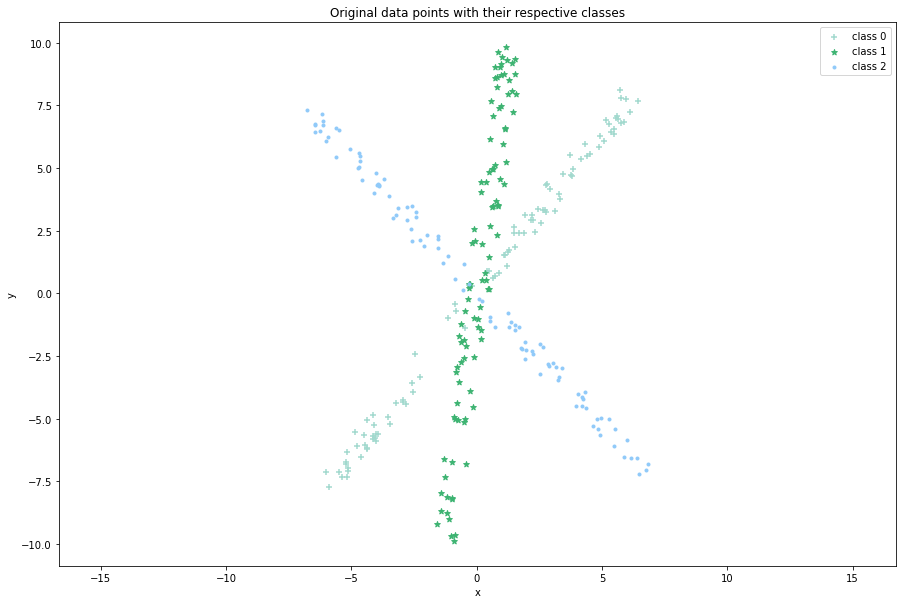

In [18]:
scatter_plot(X, y, "Original data points with their respective classes", "x", "y")

The data has **3 different clusters**. Notice however how some of data points of the clusters are overlapped. This may difficult the correct clustering of the algorithms that will be applied in the next sections. 

***

## **3. Crisp Clustering** <a class="anchor" id="third-bullet"></a>

### **3.1. Results** <a class="anchor" id="third-first-bullet"></a>

In [19]:
mode = "Crisp"
M = 3
n_attempts = 10
n_iter = 100
eps = 0.001
u, theta_M, cost_evolution = do_crisp_clust(X, M, n_iter, n_attempts, eps)


Attempt 0
        Iteration 0
             Cost: 536.4029990407726
        Iteration 1
             Cost: 533.2592688461114
        Iteration 2
             Cost: 184.28633089494582
        Iteration 3
             Cost: 22.50669631867157
        Iteration 4
             Cost: 22.45587307037521
        Iteration 5
             Cost: 22.45587307037521

Attempt 1
        Iteration 0
             Cost: 536.5249060321031
        Iteration 1
             Cost: 533.2592688461114
        Iteration 2
             Cost: 184.28633089494582
        Iteration 3
             Cost: 22.50669631867157
        Iteration 4
             Cost: 22.45587307037521
        Iteration 5
             Cost: 22.45587307037521

Attempt 2
        Iteration 0
             Cost: 50.76684073706322
        Iteration 1
             Cost: 22.45587307037521
        Iteration 2
             Cost: 22.45587307037521

Attempt 3
        Iteration 0
             Cost: 637.4247190262957
        Iteration 1
             Cost: 187

In [20]:
print(f"θ ({mode}): {theta_M}")

θ (Crisp): [ 1.43959494 -0.81827823  0.91448639]


### **3.2. Predicted clusters** <a class="anchor" id="third-second-bullet"></a>

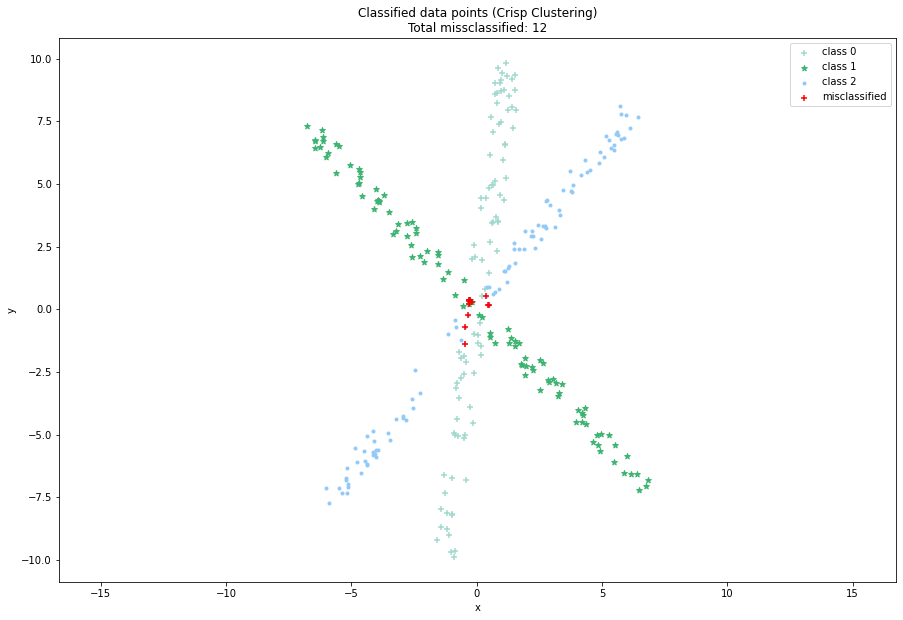

In [21]:
y_pred = np.zeros((len(u)))
for i in range(len(u)):
    if u[i][0] == 1.0:
        y_pred[i] = 0
    elif u[i][1] == 1.0:
        y_pred[i] = 1
    else:
        y_pred[i] = 2
y_pred = np.reshape(y_pred, (-1, 1))
plot_predicted_clusters(X, y_pred, u, mode)

We can see that the crisp clustering has classified correctly almost all the data points, aside from 12 points (in the region where the three clusters overlap) that have been missclassified. 

### **3.3. Cost evolution** <a class="anchor" id="third-third-bullet"></a>

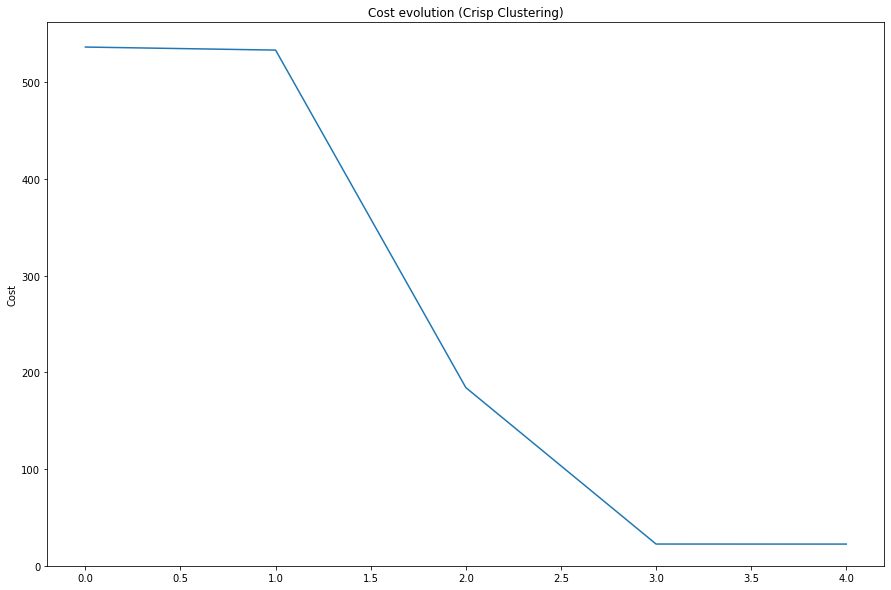

In [22]:
cost_evolution.pop(0)
plot_cost(cost_evolution, mode)

The cost evolution decreases rapidly in the first iterations but converge to a local minimum in the last two iterations. The cost has not reached the 0 value, as we have seen that we have missclassified 12 points. 

In [23]:
get_measures_cluster(y, y_pred)

V-Measure: 0.8432772039086082
Contingency matrix:
[[  1   2  97]
 [ 91   3   6]
 [  0 100   0]]


We can see that from the contingency matrix we have missclassified 12 points, those that have been plotted in the previous graph.

***

## **4. Fuzzy Clustering** <a class="anchor" id="fourth-bullet"></a>

### **4.1. Results** <a class="anchor" id="fourth-first-bullet"></a>

In [24]:
mode = "Fuzzy"
q = 2
u, theta_M, cost_evolution = do_fuzzy_clustering(X, M, n_iter, n_attempts, eps, q)


Attempt 0
        Iteration 0
             Cost: 45.427777158800964
        Iteration 1
             Cost: 21.13913422769157
        Iteration 2
             Cost: 21.086394048570288
        Iteration 3
             Cost: 21.086279246208825

Attempt 1
        Iteration 0
             Cost: 667.4661574038574
        Iteration 1
             Cost: 88.6796426792622
        Iteration 2
             Cost: 21.265975643057796
        Iteration 3
             Cost: 21.08656679929266
        Iteration 4
             Cost: 21.08627954642639

Attempt 2
        Iteration 0
             Cost: 751.1612335653949
        Iteration 1
             Cost: 445.76831832995555
        Iteration 2
             Cost: 258.352509534424
        Iteration 3
             Cost: 245.92417980346258
        Iteration 4
             Cost: 131.67235303000248
        Iteration 5
             Cost: 22.346974030906498
        Iteration 6
             Cost: 21.087812067066633
        Iteration 7
             Cost: 21.086281

In [25]:
print(f"θ ({mode}): {theta_M}")

θ (Fuzzy): [ 0.91451424 -0.81806192  1.4402725 ]


### **4.2. Predicted clusters** <a class="anchor" id="fourth-second-bullet"></a>

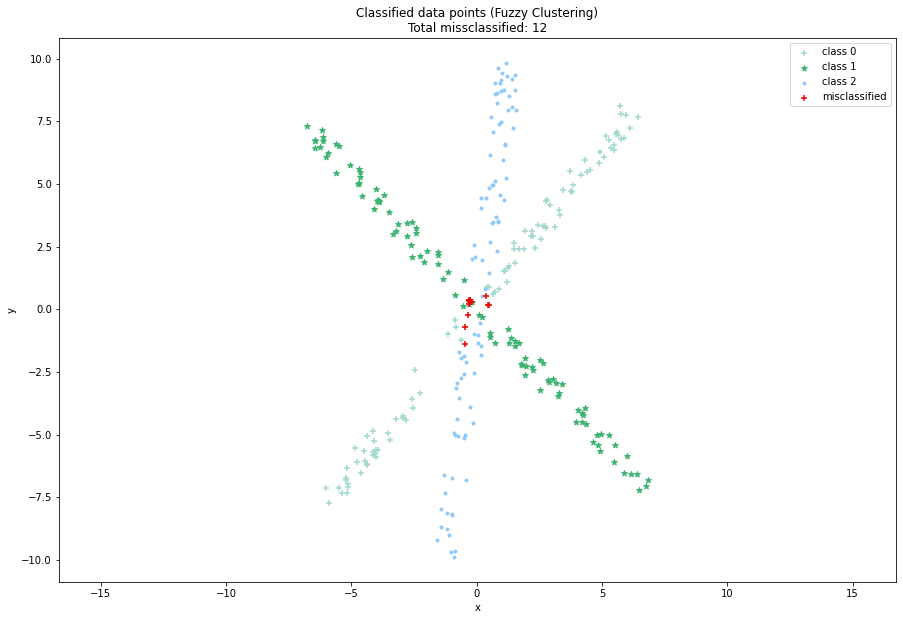

In [26]:
y_pred = np.zeros((len(u)))
for i in range(len(u)):
    y_pred[i] = np.argmax(u[i])
y_pred = np.reshape(y_pred, (-1, 1))
plot_predicted_clusters(X, np.array(y_pred), u, mode)

Just as with the crisp clustering, the fuzzy clustering has managed to classify correctly almost all data points but has missclassified the 12 points in the overlapped region.

### **4.3. Cost evolution** <a class="anchor" id="fourth-third-bullet"></a>

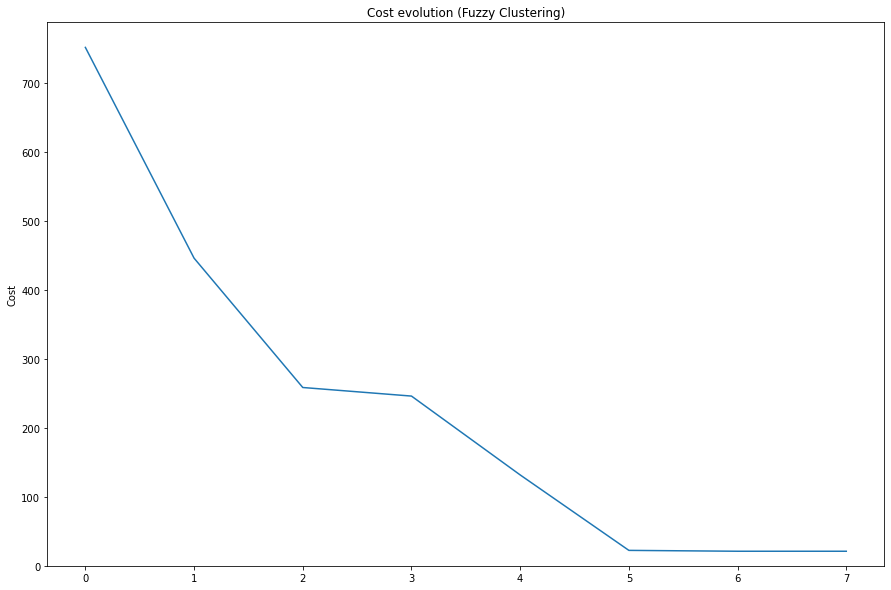

In [27]:
cost_evolution.pop(0)
plot_cost(cost_evolution, mode)

We can see that the cost evolution has converged in more iterations than the crisp clustering.

In [28]:
get_measures_cluster(y, y_pred)

V-Measure: 0.8432772039086082
Contingency matrix:
[[ 97   2   1]
 [  6   3  91]
 [  0 100   0]]


We can see that from the contingency matrix we have missclassified 12 points, those that have been plotted in the previous graph.